In [1]:
from ast import literal_eval
import pandas as pd 
from tqdm.notebook import tqdm
from IPython import display
import json
import shutil

In [2]:
# train path depends on users 
# make sure that you have data dir tree like this 
# -ROOT_PATH
#  --train.csv
#  --train_images
#    ---video_0
#    ---video_1
#    ---video_2
#  --annotations
#  --image_data


ROOT_PATH = '/media/volume4/joon_fun/tensorflow-great-barrier-reef'
TRAIN_PATH = f'{ROOT_PATH}/train_images'
background_prop = 0.1

In [3]:
# read train.csv as a dataframe

df = pd.read_csv(f'{ROOT_PATH}/train.csv')
n_with_annotations = (df['annotations'] != '[]').sum()

df = pd.concat([
  df[df['annotations'] != '[]'],
  df[df['annotations'] == '[]'].sample(int(n_with_annotations*background_prop))
]).sample(frac=1).reset_index(drop=True)

df['annotations'] = df['annotations'].apply(literal_eval)

In [4]:
# make columns 
df['num_bbox'] = df['annotations'].apply(lambda x: len(x))
df['path'] = df.apply(lambda row: f"{TRAIN_PATH}/video_{row['video_id']}/{row['video_frame']}.jpg", axis=1)

data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")
df.tail(5)

No BBox: 9.08% | With BBox: 90.92%


video_id  sequence  video_frame  sequence_frame image_id  \
5405         0     40258          243             243    0-243   
5406         2     22643         5749             386   2-5749   
5407         0     53708         9231             346   0-9231   
5408         0      8399         4706             968   0-4706   
5409         1      8503         4503             675   1-4503   

                                            annotations  num_bbox  \
5405  [{'x': 869, 'y': 240, 'width': 27, 'height': 24}]         1   
5406  [{'x': 498, 'y': 311, 'width': 52, 'height': 3...        15   
5407  [{'x': 1005, 'y': 304, 'width': 40, 'height': ...         1   
5408  [{'x': 498, 'y': 371, 'width': 47, 'height': 4...         2   
5409  [{'x': 655, 'y': 629, 'width': 55, 'height': 6...         2   

                                                   path  
5405  /media/volume4/joon_fun/tensorflow-great-barri...  
5406  /media/volume4/joon_fun/tensorflow-great-barri...  
5407  /media/volume4/joon_fun/tensorflow-great-barri...  
5408  /media/volume4/joon_fun/tensorflow-great-barri...  
5409  /media/volume4/joon_fun/tensorflow-great-barri...

In [5]:
# converting to coco 

def create_coco_json(df):
  
  annotation_id = 0 
  images = []
  annotations = []
  
  categories = [{'id': 0, 'name': 'cots'}]
  
  for i, row in tqdm(df.iterrows(), total = len(df)):
    
    images.append({
      "id": i,
      "file_name": f"{row['image_id']}.jpg",
      "height": 720,
      "width": 1280
    })
    for bbox in row['annotations']:
      annotations.append({
        "id": annotation_id,
        "image_id": i,
        "category_id": 0,
        "bbox": list(bbox.values()),
        "area": bbox['width'] * bbox['height'],
        "segmentation": [],
        "iscrowd": 0
      })
      annotation_id+=1
      
  json_file = {'categories':categories, 'images':images, 'annotations':annotations}
  return json_file     

In [6]:
train_df = df[df['video_id']!=1]
valid_df = df[df['video_id']==1]

json_train = create_coco_json(train_df)
json_valid = create_coco_json(valid_df)

  0%|          | 0/3155 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

In [7]:
# dump json files
with open(f'{ROOT_PATH}/annotations/annotations_train.json', 'w', encoding='utf-8') as f:
  json.dump(json_train, f, ensure_ascii=True, indent=4)
with open(f'{ROOT_PATH}/annotations/annotations_valid.json', 'w', encoding='utf-8') as f:
  json.dump(json_valid, f, ensure_ascii=True, indent=4)


In [9]:
# copy image files for training/validation

for i, row in tqdm(train_df.iterrows(), total = len(train_df)):
  fname = f"{row['image_id']}.jpg"
  shutil.copyfile(row['path'], f"{ROOT_PATH}/image_data/train/{fname}")

for i, row in tqdm(valid_df.iterrows(), total = len(valid_df)):
  fname = f"{row['image_id']}.jpg"
  shutil.copyfile(row['path'], f"{ROOT_PATH}/image_data/valid/{fname}")
  

  0%|          | 0/3155 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

In [10]:
### to check if everything works fine  

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
from random import sample

In [11]:
coco = COCO(f"{ROOT_PATH}/annotations/annotations_train.json")
img_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


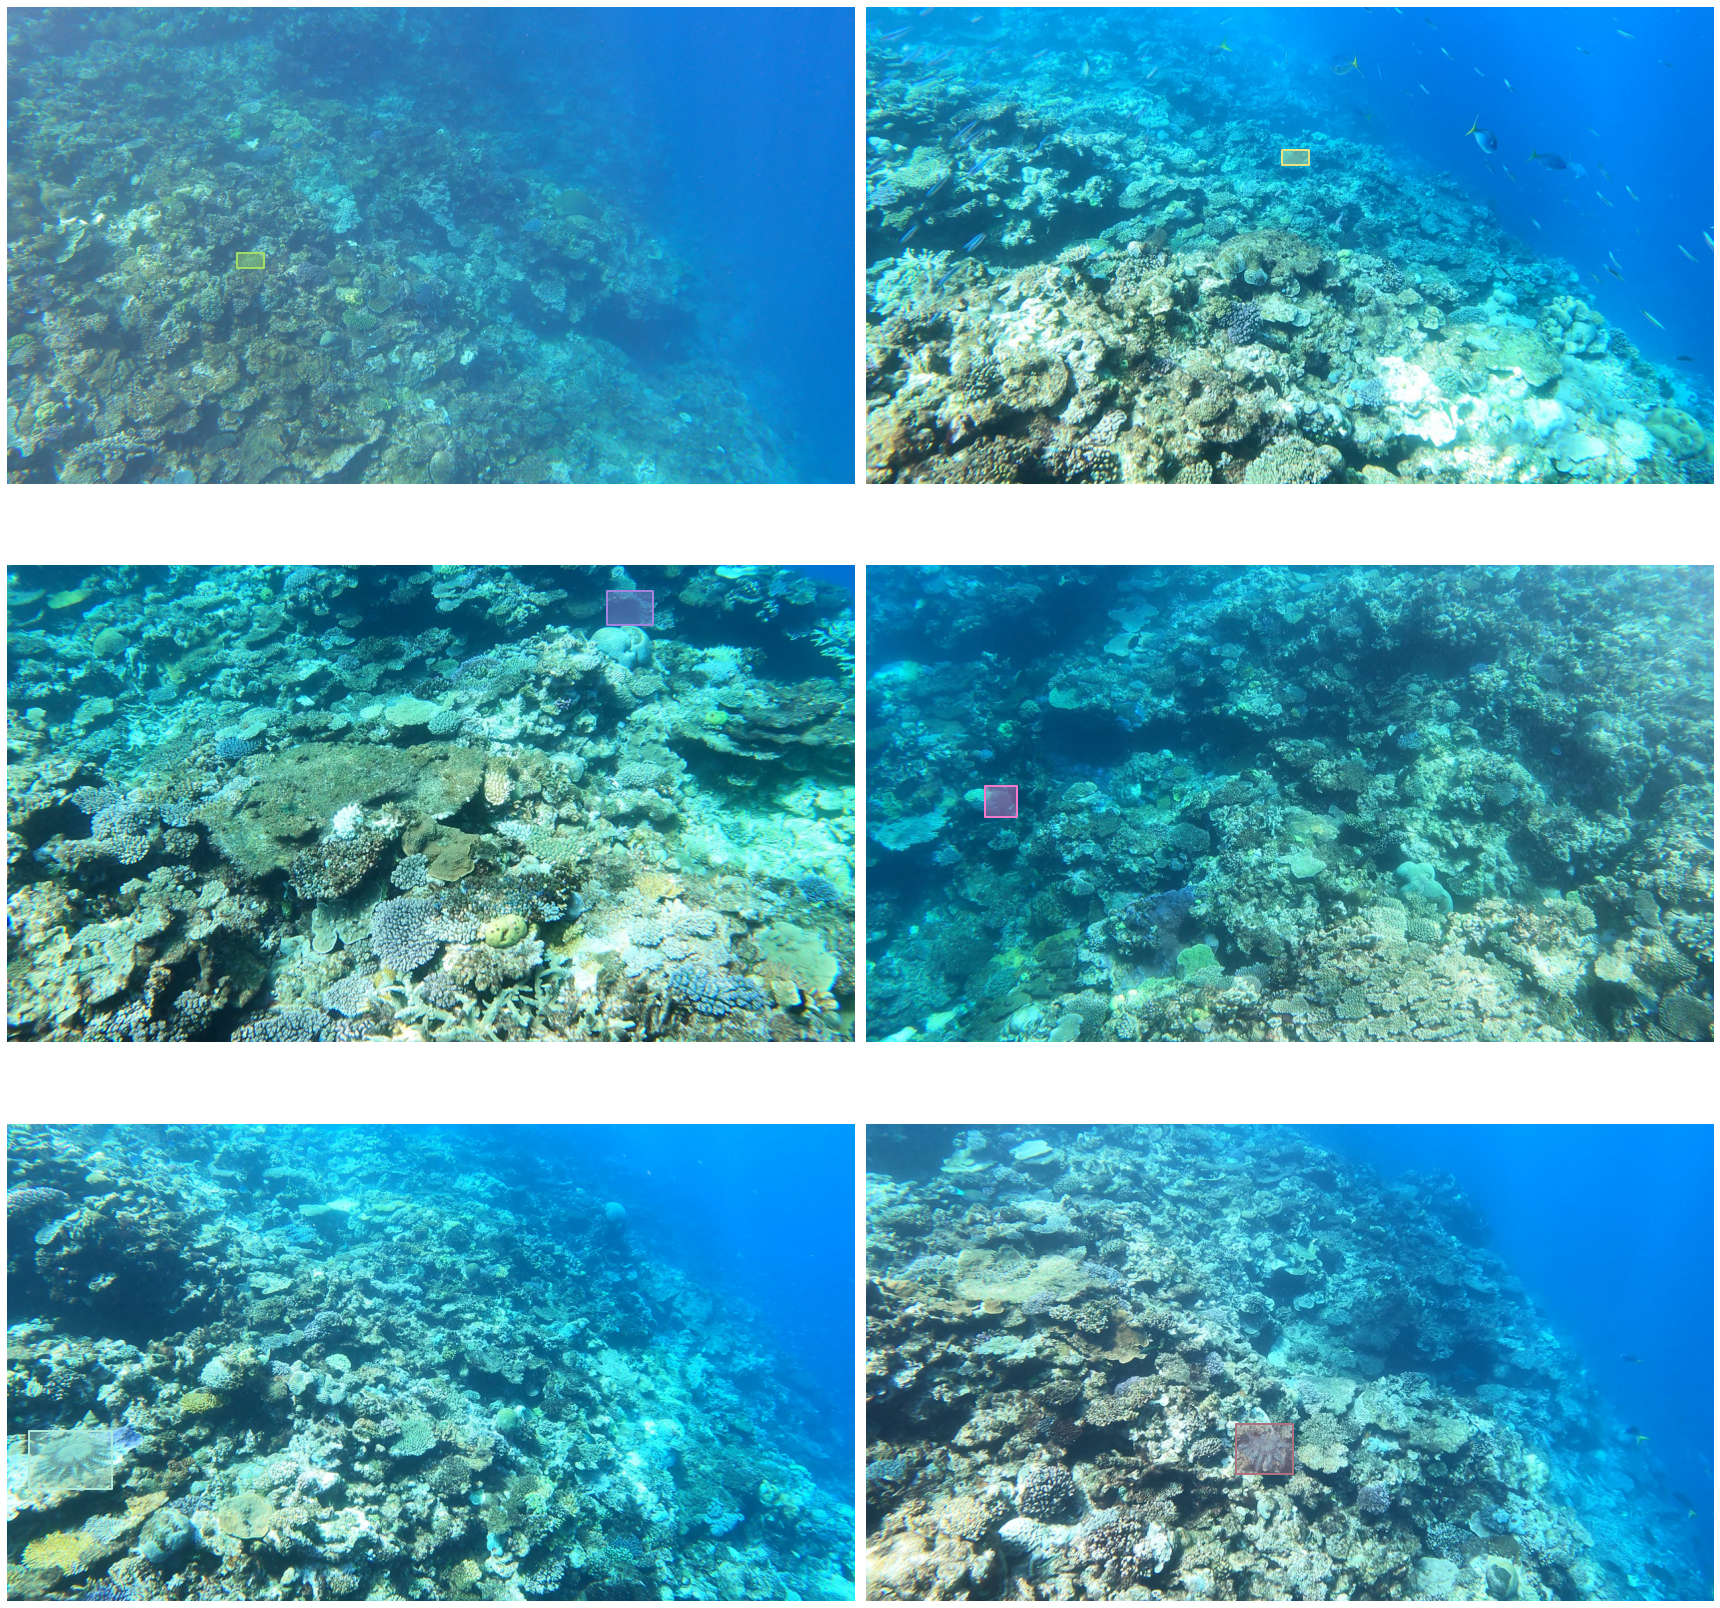

In [12]:
n_row = 3
n_col = 2


imgs = coco.loadImgs(sample(img_ids, n_row*n_col))
_, axs = plt.subplots(n_row, n_col, figsize=(12*n_col, 8 * n_row))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
  img_img = Image.open(f"{ROOT_PATH}/image_data/train/{img['file_name']}")
  anns = coco.loadAnns(coco.getAnnIds(imgIds=[img['id']]))
  ax.imshow(img_img)
  plt.sca(ax)
  coco.showAnns(anns, draw_bbox=True)
  plt.axis('off')
plt.tight_layout()  
plt.show()  